In [ ]:
# https://colab.research.google.com/github/DhavalTaunk08/NLP_scripts/blob/master/sentiment_analysis_using_roberta.ipynb#scrollTo=HMqQTafXEaei

In [1]:
!nvidia-smi

Wed May 31 14:49:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 455.45.01    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090    Off  | 00000000:1B:00.0 Off |                  N/A |
| 39%   47C    P2   112W / 350W |  14617MiB / 24268MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 3090    Off  | 00000000:3E:00.0 Off |                  N/A |
| 35%   

In [2]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from collections import defaultdict
from textwrap import wrap
from datetime import datetime
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import re
# import emoji
# import nltk
# nltk.download('words')
# words = set(nltk.corpus.words.words())

/home/jmaharja/anaconda3/envs/gpu/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
current_time = datetime.now().strftime("%Y_%m_%d-%I_%M%p")
current_time

'2023_05_31-02_49PM'

In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
df1 =pd.read_csv('/data/jmharja/projects/robertaForTweetAnalysis/input/Tweets_Spring_Summer_2021_coded.csv',lineterminator='\n',skipinitialspace=True,)
# df1['label']= 1
# df1.drop(df1.columns[[0, 2,3,4]], axis=1, inplace=True)
df1.shape

(4467, 5)

In [6]:
df1_pos = df1.loc[(df1['Substance'] != 'X') & (df1['Use'] != 'X') & (df1['Intent'] != 'X')]
df1_neg = df1.loc[(df1['Substance'] == 'X') & (df1['Use'] == 'X') & (df1['Intent'] == 'X')]

df1_pos.drop(df1_pos.columns[[0, 2,3,4]], axis=1, inplace=True)
df1_neg.drop(df1_neg.columns[[0, 2,3,4]], axis=1, inplace=True)
df1_pos['label']= 1
df1_neg['label']= 0
df1_neg.shape,  df1_pos.shape

/tmp/ipykernel_869005/563259533.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_pos.drop(df1_pos.columns[[0, 2,3,4]], axis=1, inplace=True)
/tmp/ipykernel_869005/563259533.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_neg.drop(df1_neg.columns[[0, 2,3,4]], axis=1, inplace=True)
/tmp/ipykernel_869005/563259533.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df

((3605, 2), (456, 2))

In [7]:
# prediction result reviewed by Dr. King added for re-training
df2 =pd.read_csv('/data/jmharja/projects/robertaForTweetAnalysis/input/ReviewedPrediction.csv',lineterminator='\n', skipinitialspace=True,)
df2.rename(columns = {'tweet':'Tweet'}, inplace = True)
df2 = df2.loc[:, ~df2.columns.str.contains('^Unnamed')]
df2.shape

(821, 4)

In [8]:
df2_pos = df2.loc[(df2['type'] == 1) | (df2['use'] == 1) | (df2['intent'] ==1)]
df2_neg = df2.loc[(df2['type'] != 1) & (df2['use'] != 1) & (df2['intent'] !=1)]
df2_pos.drop(df2_pos.columns[[2,3,1]], axis=1, inplace=True)
df2_neg.drop(df2_neg.columns[[2,3,1]], axis=1, inplace=True)
df2_pos['label']= 1
df2_neg['label']= 0
df2_neg.shape,  df2_pos.shape

/tmp/ipykernel_869005/3210941477.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_pos.drop(df2_pos.columns[[2,3,1]], axis=1, inplace=True)
/tmp/ipykernel_869005/3210941477.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_neg.drop(df2_neg.columns[[2,3,1]], axis=1, inplace=True)
/tmp/ipykernel_869005/3210941477.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_p

((641, 2), (180, 2))

In [9]:
# iteration (predicted result added for re-training)
df3 =pd.read_csv('/data/jmharja/projects/robertaForTweetAnalysis/input/ReviewedPrediction_1.csv',lineterminator='\n', skipinitialspace=True,)
df3_pos= df3.loc[df3['label']==1]
df3_neg = df3.loc[df3['label']==0]
df3_neg.shape, df3_pos.shape

((412, 2), (710, 2))

In [11]:
# # predicted result from 202212 filtered by chatgpt added for retraining
# df4_pos =pd.read_csv('test_result/chatgpt/all_pos.csv',lineterminator='\n', skipinitialspace=True,)
# df4_neg =pd.read_csv('test_result/chatgpt/all_neg.csv',lineterminator='\n', skipinitialspace=True,)
# df4_pos.drop(df4_pos.columns[[0]], axis=1, inplace=True)
# df4_neg.drop(df4_neg.columns[[0]], axis=1, inplace=True)
# df4_pos['label']= 1
# df4_neg['label']= 0
# df4_neg.shape, df4_pos.shape

In [10]:
# df_pos = pd.concat([df1_pos, df2_pos, df3_pos, df4_pos])
# df_neg = pd.concat([df1_neg, df2_neg, df3_neg, df4_neg])
df_pos = pd.concat([df1_pos, df2_pos, df3_pos])
df_neg = pd.concat([df1_neg, df2_neg, df3_neg])
df_neg.shape,  df_pos.shape

((4658, 2), (1346, 2))

In [11]:
# foldername = '400Vs2000'
df1 = df_pos[:1150]
df2 = df_neg[:4575]
df = pd.concat([df1,df2])
df.shape

(5725, 2)

In [14]:
# df2 =pd.read_csv('/users/kent/jmaharja/drugAbuse/input/2020_01_31_CleanedTweets.csv',
#                 lineterminator='\n',
#                 skipinitialspace=True
#                 )
# df2.drop(df2.columns[[0, 1]], axis=1, inplace=True)
# df2.rename({'text': 'Tweet'}, axis=1, inplace=True)
# df2['label'] = 0
# df4 = df2[1160000:]
# df2 = df2[:800]
# df4 = df4[:200]
# df2.shape, df4.shape

In [12]:
# df_test =pd.read_csv('/users/kent/jmaharja/drugAbuse/finetune/test_new.csv',
# #                    error_bad_lines=False,
#                 lineterminator='\n',
#                 skipinitialspace=True
#                 )
# df_test.drop(df_test.columns[[1, 2, 3]], axis=1, inplace=True)
# # df_test.rename({'text': 'Tweet'}, axis=1, inplace=True)
# # df_test['label']=/ 1
# df_test = df_test.rename(columns={df_test.columns[1]: 'label'})
df_test_neg = df_neg[4575:]
df_test_pos = df_pos[1150:]
df3 = pd.concat([df_test_pos,df_test_neg])
df3.shape

(279, 2)

# DATA PREPROCESSING

In [16]:
# #choosing sequence length
# token_lens = []
# for txt in df.Tweet:
#   tokens = tokenizer.encode(txt)
#   token_lens.append(len(tokens))
# sns.distplot(token_lens)
# plt.xlim([0, 200])
# plt.xlabel('Token count')

# MAX_LEN = 80

In [25]:
MAX_LEN = 128
from transformers import RobertaTokenizerFast
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

# Create the tokenizer from a trained one
tokenizer_folder = '/data/jmharja/projects/robertaForTweetAnalysis/output/oct2022/TokRoBERTa'
tokenizer = RobertaTokenizerFast.from_pretrained(tokenizer_folder, max_len=MAX_LEN)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'RobertaTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'RobertaTokenizerFast'.


In [26]:
from torch.utils.data import Dataset
class Tweet_DataSet(Dataset):
   def __init__(self, data, tokenizer, max_len):
    self.data = data
    self.data['Tweet'] = self.data['Tweet'].map(lambda x: self.cleaner(x))
    self.tokenizer = tokenizer
    self.max_len = max_len
    
  
   def __len__(self):
    return len(self.data)

   def cleaner(self, tweet):
#         print(tweet)
        tweet = re.sub("@[A-Za-z0-9]+","", tweet) #Remove @ sign
        tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) #Remove http links
        tweet = " ".join(tweet.split())
        #     tweet = ''.join(c for c in tweet if c not in emoji.UNICODE_EMOJI) #Remove Emojis
        #     tweet = tweet.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
        #     tweet = " ".join(w for w in nltk.wordpunct_tokenize(tweet) \
        #          if w.lower() in words or not w.isalpha())
        return tweet
    
        
  
   def __getitem__(self, index:int):
    data_row = self.data.iloc[index]
    tweet = data_row.Tweet
    labels = data_row['label']
    encoding = tokenizer.encode_plus(tweet,
                                     None,
                                     max_length = MAX_LEN,
                                     truncation=True,
                                     pad_to_max_length=True,
                                     add_special_tokens=True,
                                     padding='max_length',
                                     return_token_type_ids=True)

    return {
      'tweet_text': tweet,
      'input_ids': torch.tensor(encoding.input_ids, dtype=torch.long),
      'attention_mask':  torch.tensor(encoding.attention_mask, dtype=torch.long),
      'token_type_ids': torch.tensor(encoding.token_type_ids, dtype=torch.long),
      'targets': torch.tensor(labels, dtype=torch.long)
    }

In [27]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
# df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)
df_val = df_test
df_test = df3
df_train.shape, df_val.shape, df_test.shape

((5152, 2), (573, 2), (279, 2))

In [28]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = Tweet_DataSet(df,tokenizer=tokenizer,max_len=max_len)
  return DataLoader(ds, batch_size=batch_size,num_workers=4)

BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [29]:
# from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel
# from transformers import RobertaModel, RobertaConfig, logging

class TweetModel(RobertaPreTrainedModel):
    def __init__(self, conf, n_classes):
        super(TweetModel, self).__init__(conf)
        self.roberta = transformers.RobertaModel.from_pretrained('/data/jmharja/projects/robertaForTweetAnalysis/output/oct2022/RoBERTaMLM/', config=conf)
        self.drop_out = nn.Dropout(0.5)
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.classifier = nn.Linear(768, n_classes)
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.roberta(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.drop_out(pooler)
        output = self.classifier(pooler)
        return output


In [30]:
from transformers import RobertaConfig

config = RobertaConfig(
    vocab_size=8192,
    max_position_embeddings=514,
    num_attention_heads=12,
    num_hidden_layers=6,
    type_vocab_size=1,
    hidden_size=768,
    pad_token_id=1
)

model = TweetModel(config, 2)
model = model.to(device)

Some weights of the model checkpoint at /data/jmharja/projects/robertaForTweetAnalysis/output/oct2022/RoBERTaMLM/ were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /data/jmharja/projects/robertaForTweetAnalysis/output/oct2022/RoBERTaMLM/ and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably T

In [31]:
#training
EPOCHS = 16

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
loss_fn = nn.CrossEntropyLoss().to(device)

/home/jmaharja/anaconda3/envs/gpu/lib/python3.11/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [32]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0
     
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    token_type_ids = d["token_type_ids"].to(device)
    targets = d["targets"].to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

    big_val, big_idx = torch.max(outputs, dim=1)
    correct_predictions += torch.sum(big_idx == targets)

    loss = loss_fn(outputs, targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double()/n_examples, np.mean(losses)

In [33]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids
      )
      _, preds = torch.max(outputs, dim=1)
      correct_predictions += torch.sum(preds == targets)

      loss = loss_fn(outputs, targets)
      losses.append(loss.item())

  return correct_predictions.double()/n_examples, np.mean(losses)

In [ ]:
from os.path import exists
# %%time

# set to True if you want to train the model
# otherwise use the existing trained model
FORCE_TRAIN = True

# download trained model
# !gdown --id 1QQ2d0_yFStL2rXz2eHoXpgRMvPWtMMeX

print(40*"*", 'Training')
current_time = datetime.now().strftime("%Y_%m_%d-%I_%M%p")
print(current_time)
history = defaultdict(list)
best_accuracy = 0
val_acc = 0 

for epoch in range(EPOCHS):


#   modelPath = "checkpoint/best_ftc_model_state.bin"
#   if (exists(modelPath) and FORCE_TRAIN == False ): # if model exists load it otherwise rebuild
#     torch.load(modelPath)
#     break # exit out of training
  

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))
  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(model, val_data_loader,loss_fn, device, len(df_val))

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    curr_time = datetime.now().strftime("%Y_%m_%d-%I_%M%p")
    torch.save(model.state_dict(), 'checkpoint/best_ftc_model_state'+ curr_time +'.bin')
    best_accuracy = val_acc

**************************************** Training
2023_05_31-03_00PM
Epoch 1/16
----------
Train loss 0.32225217212350193 accuracy 0.8866459627329193
Val   loss 0.2702035355614498 accuracy 0.9284467713787086

Epoch 2/16
----------
Train loss 0.19393658998526447 accuracy 0.9419642857142857
Val   loss 0.25184288301453406 accuracy 0.9301919720767888

Epoch 3/16
----------
Train loss 0.138300412988886 accuracy 0.9642857142857143
Val   loss 0.270094422222529 accuracy 0.924956369982548

Epoch 4/16
----------
Train loss 0.09323646913294142 accuracy 0.9778726708074534
Val   loss 0.32098754246059497 accuracy 0.9284467713787086

Epoch 5/16
----------
Train loss 0.07232052833546873 accuracy 0.984666149068323
Val   loss 0.35192572517553344 accuracy 0.924956369982548

Epoch 6/16
----------
Train loss 0.054923700462207514 accuracy 0.9879658385093167
Val   loss 0.4110817005114061 accuracy 0.9197207678883071

Epoch 7/16
----------
Train loss 0.0370469356147516 accuracy 0.9912655279503105
Val   loss 0.

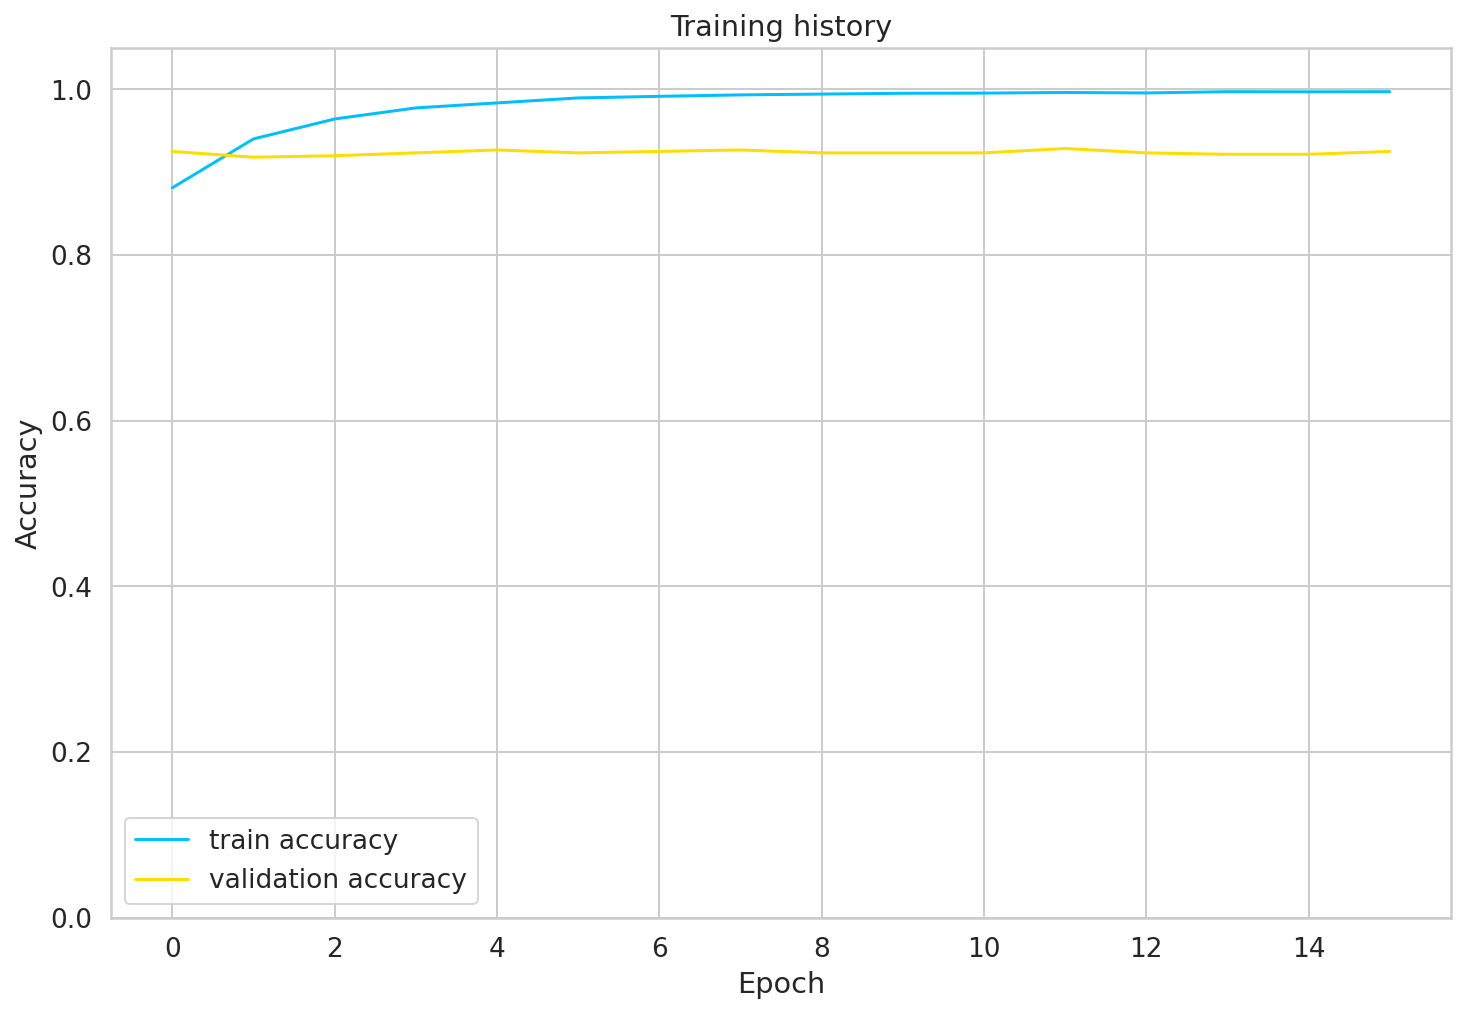

In [27]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1.05]);
plt.savefig('images/training_history '+current_time+'.png')

In [28]:
torch.save(model.state_dict(), 'checkpoint/best_ftc_model_state'+ curr_time +'.bin')

In [29]:
test_acc, _ = eval_model(model, test_data_loader, loss_fn, device, len(df_test))
test_acc.item()

0.8100358422939068

# PREDICTION


In [31]:
# model.load_state_dict(torch.load('checkpoint/best_ftc_model_state2023_01_17-02_22PM.bin'))

In [32]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["tweet_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      targets = d["targets"].to(device)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
      _, preds = torch.max(outputs, dim=1)
      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [33]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

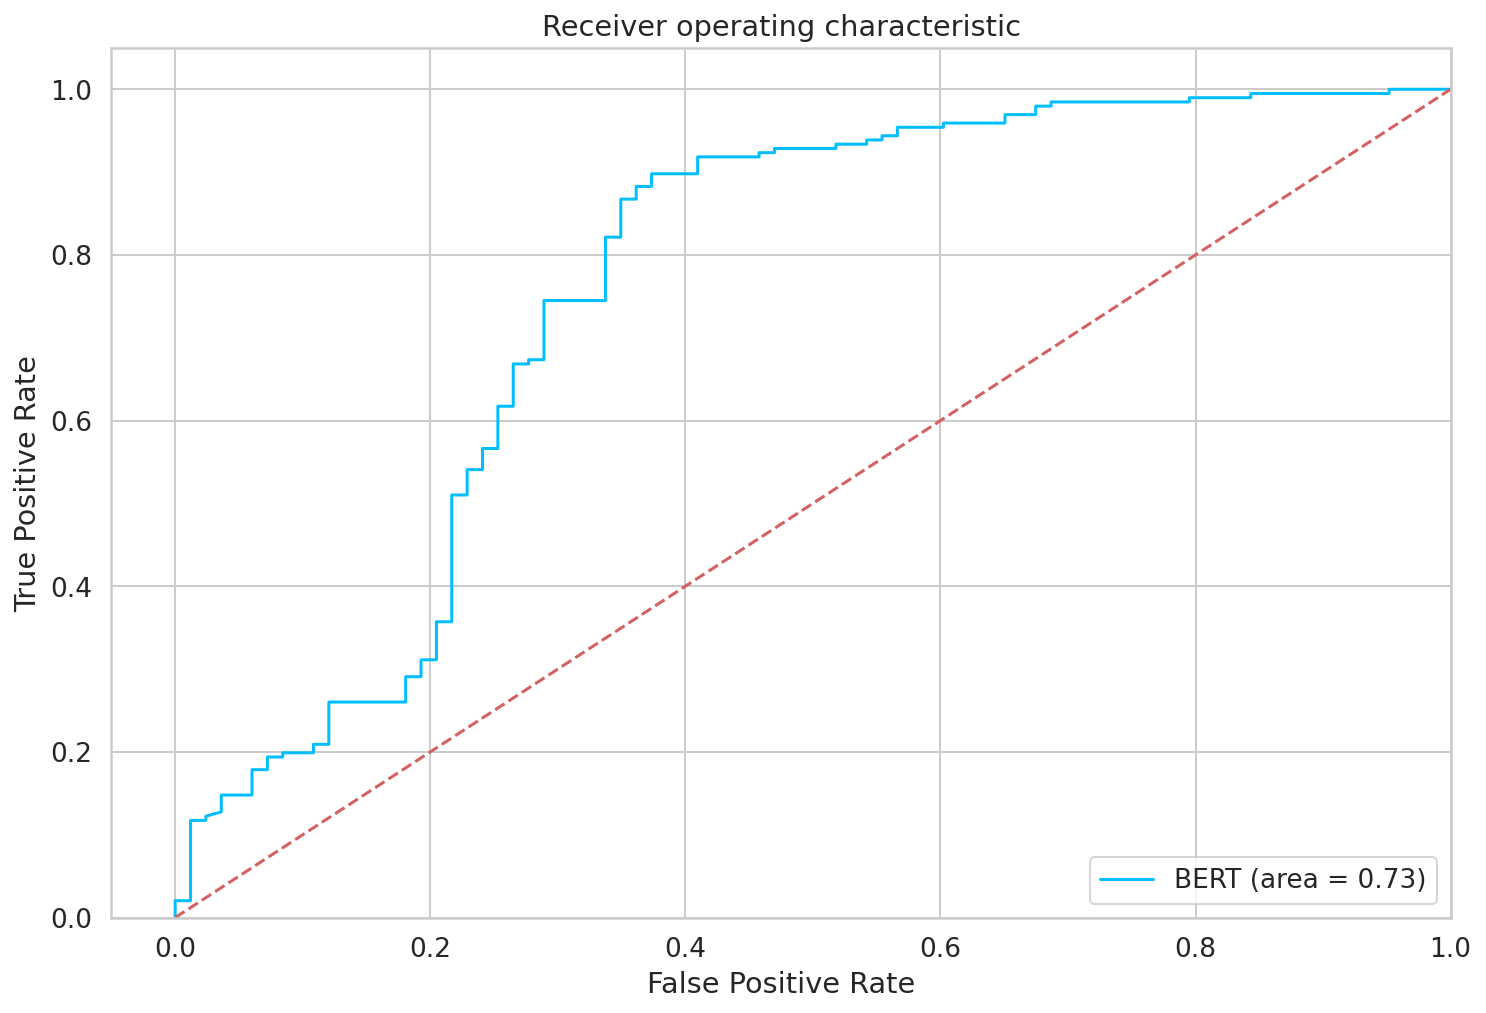

In [34]:
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test.numpy(), y_pred_probs[:, 1].numpy())
plt.figure()
plt.plot(fpr, tpr, label='BERT (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images/Log_ROC_'+ current_time +'.png')
# plt.savefig(foldername + '/Log_ROC_'+ current_time +'.png'')
plt.show()

In [35]:
y_pred_probs_pd = [y.numpy() for y in y_pred_probs]
someListOfLists = list(zip(y_review_texts, y_test.numpy(), y_pred.numpy(), y_pred_probs[:, 1:].numpy().squeeze(), y_pred_probs_pd ))
npa = np.asarray(someListOfLists)
dff = pd.DataFrame(someListOfLists, columns = ['readme', 'Real', 'Predicted', 'Pred-prob', 'All Pred-probs' ])
dff

/users/kent/jmaharja/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,readme,Real,Predicted,Pred-prob,All Pred-probs
0,"RT : Roll me like a blunt, because 2020 is her...",1,1,0.999867,"[0.00013273073, 0.9998672]"
1,RT : drunk af,1,1,0.999677,"[0.00032328605, 0.9996767]"
2,n e way i’m still kinda drunk but it’s six am ...,1,1,0.999509,"[0.00049056485, 0.99950945]"
3,RT : New Year ▪ continuing my sobriety drug an...,1,1,0.999836,"[0.0001640631, 0.99983597]"
4,I tire for guys on here... Any small thing how...,1,0,0.000028,"[0.99997175, 2.829451e-05]"
...,...,...,...,...,...
274,RT : scared of losing myself again,0,0,0.207009,"[0.79299074, 0.20700927]"
275,RT _: #NewEra_By_SaintRampalJi Don't smoking 🚬...,0,0,0.000018,"[0.9999825, 1.7537212e-05]"
276,"RT : If you wanna be a bitch, don’t be a stupi...",0,0,0.073013,"[0.92698747, 0.07301257]"
277,RT _duh_nie_luh: this decade is gonna be crazy...,0,1,0.925071,"[0.074929066, 0.92507094]"


In [36]:
dff.to_csv('test_result/'+ current_time + 'testtresult.csv')
current_time

'2023_02_20-03_08PM'

In [37]:
print(classification_report(y_test, y_pred, target_names=['Y', 'N']))

              precision    recall  f1-score   support

           Y       0.75      0.54      0.63        83
           N       0.83      0.92      0.87       196

    accuracy                           0.81       279
   macro avg       0.79      0.73      0.75       279
weighted avg       0.80      0.81      0.80       279



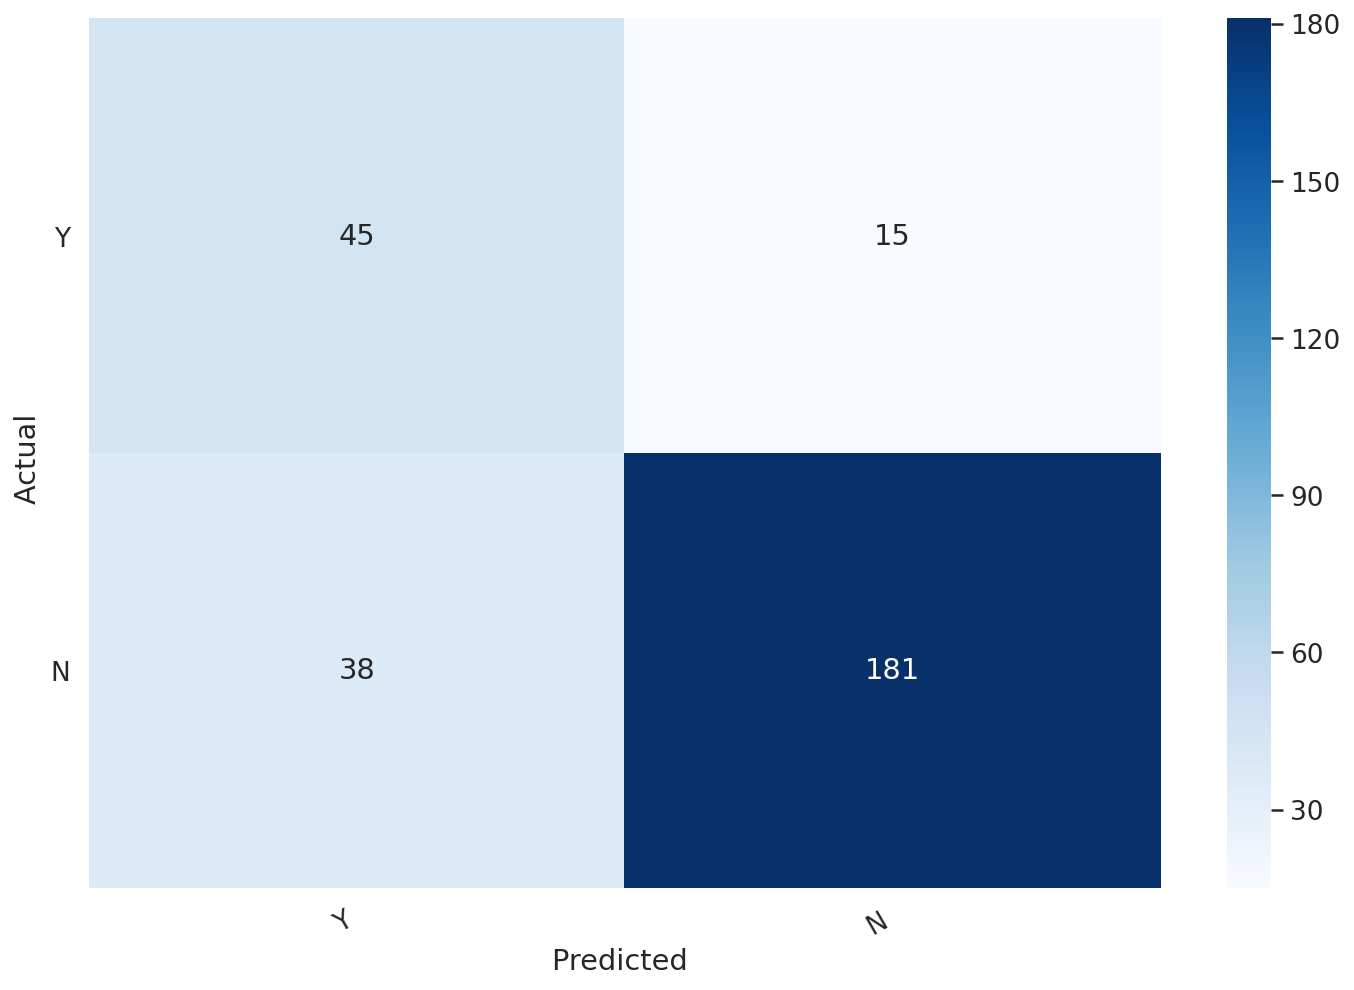

In [38]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('Actual ')
  plt.xlabel('Predicted ')
  plt.savefig('confusion_matrix/'+ 'cm_'+current_time + '.png')


cm = confusion_matrix(y_pred, y_test)
df_cm = pd.DataFrame(cm, index=['Y', 'N'], columns=['Y', 'N'])
show_confusion_matrix(df_cm)

# PREDICTION ON REAL DATA

In [37]:
df_pred =pd.read_csv('/users/kent/jmaharja/drugAbuse/input/2020_01_01.csv',lineterminator='\n',   skipinitialspace=True)
df_pred.drop(df_pred.columns[[0, 1,2, 4]], axis=1, inplace=True)
df_pred = df_pred.rename(columns={df_pred.columns[0]: 'Tweet'})
df_pred['label']= 1

In [38]:
## df_pred =pd.read_csv('/users/kent/jmaharja/drugAbuse/input/2022_11.csv',lineterminator='\n',skipinitialspace=True)
# df_pred = pd.read_fwf('/users/kent/jmaharja/drugAbuse/input/2022_11.csv')
# df_pred['label']= 1

In [39]:
df_pred.shape

(1115630, 2)

In [40]:
# from sklearn.utils import shuffle
# df_pred = shuffle(df_pred)

In [41]:
# df_pred = df_pred[:150000]
# df_pred = df_pred[150000:160000]
# df_pred = df_pred[160000:170000]
# df_pred = df_pred[170000:180000]
# df_pred = df_pred[180000:190000]
# df_pred = df_pred[190000:200000]
# df_pred = df_pred[230000:240000]
df_pred= df_pred[250000:260000]
# df_pred = df_pred[1200:2000]

In [42]:
pred_data_loader = create_data_loader(df_pred, tokenizer, MAX_LEN, BATCH_SIZE)

In [43]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, pred_data_loader)

In [44]:
y_pred_probs_pd = [y.numpy() for y in y_pred_probs]
someListOfLists = list(zip(y_review_texts, y_test.numpy(), y_pred.numpy(), y_pred_probs[:, 1:].numpy().squeeze(), y_pred_probs_pd ))
npa = np.asarray(someListOfLists)
dff = pd.DataFrame(someListOfLists, columns = ['tweet', 'Real', 'Predicted', 'Pred-prob', 'All Pred-probs' ])
dff

/users/kent/jmaharja/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,tweet,Real,Predicted,Pred-prob,All Pred-probs
0,"RT : 😈 here y’all go , he cums at the end 💋 //...",1,0,0.000133,"[0.9998672, 0.00013283546]"
1,RT : african parents be like it hurts my feeli...,1,0,0.000124,"[0.9998764, 0.00012365289]"
2,RT _scopes: Jan 1st: There are times when we k...,1,0,0.000126,"[0.999874, 0.00012598385]"
3,"Mr, president",1,0,0.000121,"[0.99987876, 0.00012119376]"
4,RT _kag: Minneapolis man charged with 13 count...,1,0,0.000120,"[0.9998796, 0.00012039473]"
...,...,...,...,...,...
9995,"RT : See photos of BTS, Post Malone and Dua Li...",1,0,0.000135,"[0.9998648, 0.00013521823]"
9996,RT : Happy New Year. Love Blessing❤️😍,1,0,0.000123,"[0.9998772, 0.00012271144]"
9997,Kk ill watch big fan btw can i have a shoutuot...,1,0,0.000134,"[0.99986637, 0.00013356957]"
9998,RT : I can’t believe my little Novalee is 5 to...,1,0,0.000121,"[0.9998791, 0.000120865894]"


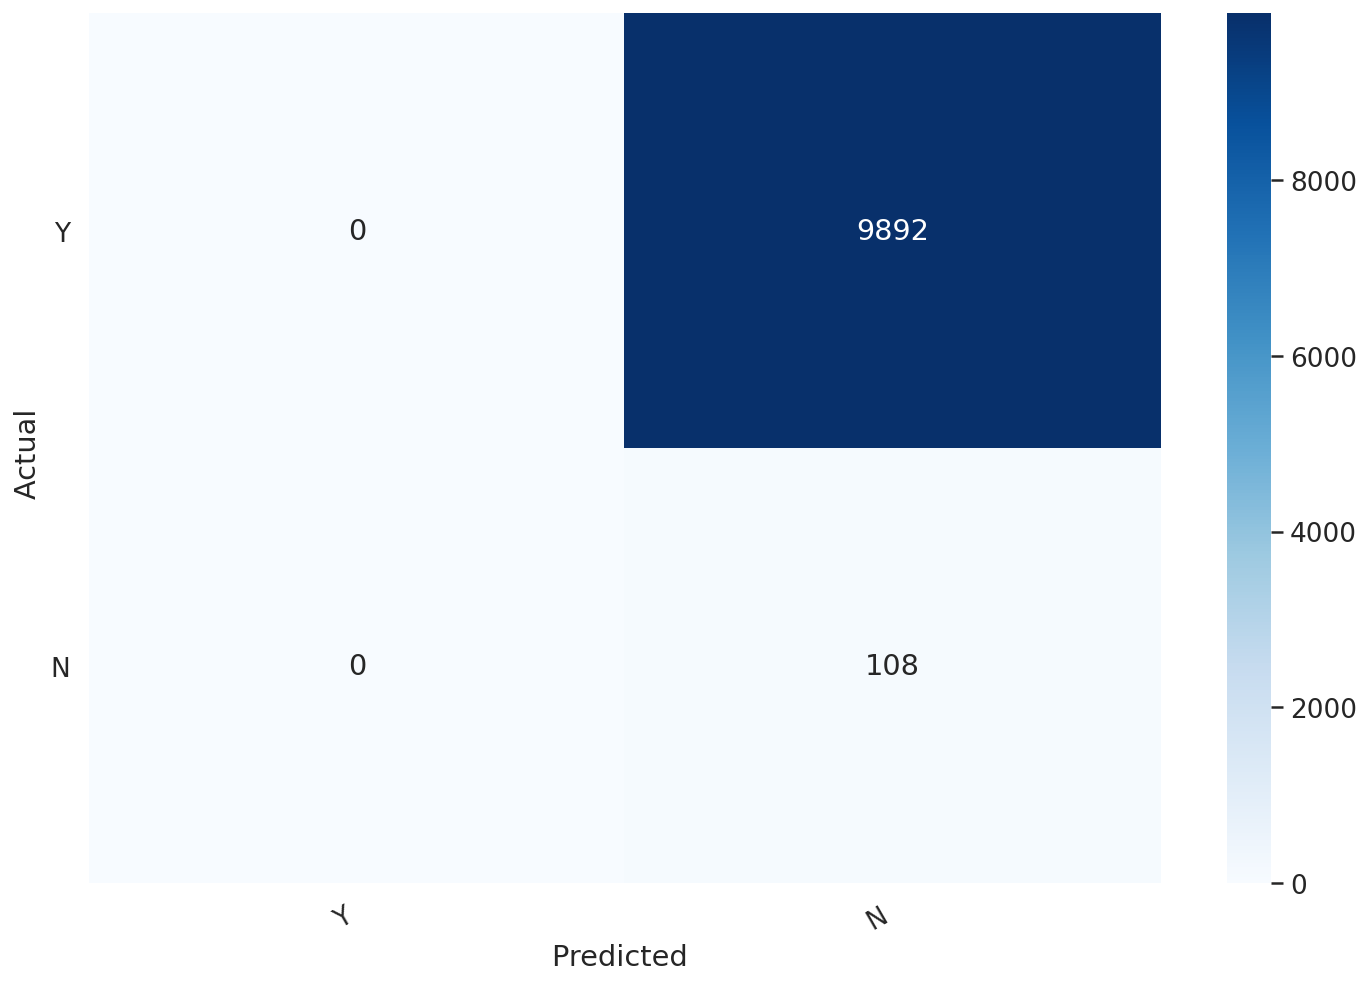

In [45]:
cm = confusion_matrix(y_pred, y_test)
df_cm = pd.DataFrame(cm, index=['Y', 'N'], columns=['Y', 'N'])
show_confusion_matrix(df_cm)

In [46]:
# dff.to_csv('test_result/'+ current_time + 'prediction_result.csv')

In [47]:
dff[dff['Predicted']==1]

,tweet,Real,Predicted,Pred-prob,All Pred-probs
149,RT : Girls really go to a dudes crib and survi...,1,1,0.999592,"[0.0004080752, 0.9995919]"
159,"RT : Honestly, y’all really have to be idiots....",1,1,0.999584,"[0.00041635236, 0.99958366]"
166,"RT : Happy new year, Wonho Happy new year, Mon...",1,1,0.894874,"[0.10512604, 0.89487404]"
219,Ayeee it’s lit,1,1,0.919856,"[0.08014378, 0.91985625]"
265,RT : Me tonight once that liquor hit!!!!,1,1,0.999720,"[0.0002803828, 0.99971956]"
...,...,...,...,...,...
9385,RT : Q: would you either visit a country where...,1,1,0.999393,"[0.0006073762, 0.9993926]"
9639,so this year I’m getting mimosa drunk with som...,1,1,0.999657,"[0.00034285616, 0.99965715]"
9669,RT : I have never seen a sober girl taking adv...,1,1,0.999551,"[0.0004494733, 0.9995505]"
9793,RT : How I drink wine after successfully defra...,1,1,0.999445,"[0.0005547086, 0.99944526]"


In [48]:
dff[dff['Predicted']==0]

,tweet,Real,Predicted,Pred-prob,All Pred-probs
0,"RT : 😈 here y’all go , he cums at the end 💋 //...",1,0,0.000133,"[0.9998672, 0.00013283546]"
1,RT : african parents be like it hurts my feeli...,1,0,0.000124,"[0.9998764, 0.00012365289]"
2,RT _scopes: Jan 1st: There are times when we k...,1,0,0.000126,"[0.999874, 0.00012598385]"
3,"Mr, president",1,0,0.000121,"[0.99987876, 0.00012119376]"
4,RT _kag: Minneapolis man charged with 13 count...,1,0,0.000120,"[0.9998796, 0.00012039473]"
...,...,...,...,...,...
9995,"RT : See photos of BTS, Post Malone and Dua Li...",1,0,0.000135,"[0.9998648, 0.00013521823]"
9996,RT : Happy New Year. Love Blessing❤️😍,1,0,0.000123,"[0.9998772, 0.00012271144]"
9997,Kk ill watch big fan btw can i have a shoutuot...,1,0,0.000134,"[0.99986637, 0.00013356957]"
9998,RT : I can’t believe my little Novalee is 5 to...,1,0,0.000121,"[0.9998791, 0.000120865894]"


In [51]:
ones = dff[dff['Predicted']==1]['tweet']
ones.to_csv('test_result/'+ current_time+'_ones.csv')

In [ ]:
# zeros = dff[dff['Predicted']==0]['tweet']
# zeros.to_csv('test_result/2023_neg.csv')

In [50]:
dff[[ "tweet", "Predicted"]].to_csv('test_result/'+ current_time+".csv)

In [49]:
current_time

'2023_02_20-02_00PM'

# POST REVIEW

In [ ]:
# ones.tweet.tolist()

# ' '.join(ones['tweet'].tolist())
# ones.tweet.str.cat(sep=', ')